# Boeing boeing: Dance Motion Detectionn #

## CNN version 0.1 Date: 2021.9.1 ##

In [1]:
import os

import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers

## Load Dateset ##

In [2]:
data_path = os.path.join(os.getcwd(), 'data')
print(data_path)
print(os.listdir(data_path))

/Users/apple/Desktop/CG4002/CNN/data
['dws_11', 'ups_12', '.DS_Store', 'wlk_7', 'std_14', 'wlk_15', 'wlk_8', 'dws_2', 'sit_13', 'jog_9', 'ups_3', 'ups_4', 'jog_16', 'dws_1', 'sit_5', 'std_6']


In [3]:
# Load the whole data into a big dataset, this is for data/feature study prupose
folders = glob(os.path.join(data_path,'*_*'))
folders = [s for s in folders if ("csv" not in s) or (".DS_Store" not in s) or (".ipynb" not in s)]
df_all_list = []
activity_codes = {'dws':0,'jog':1,'sit':2,'std':3,'ups':4,'wlk':5}
activity_types = list(activity_codes.keys())

print(folders)

for j in folders:
    #print('j',j)
    csv_list = glob(j + '/*')
    for i in csv_list:
        label = j.split('/')[-1].split('_')[0]
        if activity_codes.get(label) == None:
            sys.exit(0)
        df = pd.read_csv(i)
        df['activity'] = activity_codes[label]
        df['sub_num'] = i[len(j)+5:-4]
        expnum = np.zeros(df.shape[0])
        df_all_list.append(df)
df_all = pd.concat(df_all_list,axis=0)
df_all = df_all.drop('Unnamed: 0',axis=1)
print(df_all.shape)
print(df_all.columns)
print(df.head(5))

['/Users/apple/Desktop/CG4002/CNN/data/dws_11', '/Users/apple/Desktop/CG4002/CNN/data/ups_12', '/Users/apple/Desktop/CG4002/CNN/data/wlk_7', '/Users/apple/Desktop/CG4002/CNN/data/std_14', '/Users/apple/Desktop/CG4002/CNN/data/wlk_15', '/Users/apple/Desktop/CG4002/CNN/data/wlk_8', '/Users/apple/Desktop/CG4002/CNN/data/dws_2', '/Users/apple/Desktop/CG4002/CNN/data/sit_13', '/Users/apple/Desktop/CG4002/CNN/data/jog_9', '/Users/apple/Desktop/CG4002/CNN/data/ups_3', '/Users/apple/Desktop/CG4002/CNN/data/ups_4', '/Users/apple/Desktop/CG4002/CNN/data/jog_16', '/Users/apple/Desktop/CG4002/CNN/data/dws_1', '/Users/apple/Desktop/CG4002/CNN/data/sit_5', '/Users/apple/Desktop/CG4002/CNN/data/std_6']
(1412865, 14)
Index(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x',
       'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.y',
       'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y',
       'userAcceleration.z', 'activity', 'sub_num'],
      dtype='object')
   Un

## Feature extraction ##

Each sample will be divided into 180 windows, inside each window we calculate min max mean std mad in time domain
We will get a 180 * 30 'image'
We should get 360 such samples

In [4]:
win_count = 180
data_all_x_list = []
data_all_y_list = []
for j in folders:
    csv_list = glob(j + '/*')
    label = j.split('/')[-1].split('_')[0]
    for i in csv_list:
        df = pd.read_csv(i, usecols = ['gravity.x','gravity.y', 'gravity.z','userAcceleration.x','userAcceleration.y','userAcceleration.z'])
        segment_size = int(df.shape[0]/win_count)
        data_x = np.zeros((1, win_count, df.shape[1] * 5))
        data_y = np.zeros(1)
        for c in range(win_count):
            start_idx = c * segment_size
            end_idx = start_idx + segment_size
            temp_list = []
            means = df[start_idx:end_idx].mean().to_numpy()
            stds = df[start_idx:end_idx].mean().to_numpy()
            mins = df[start_idx:end_idx].min().to_numpy()
            maxs = df[start_idx:end_idx].max().to_numpy()
            mads = df[start_idx:end_idx].mad().to_numpy()
            temp_list.append(means)
            temp_list.append(stds)
            temp_list.append(mins)
            temp_list.append(maxs)
            temp_list.append(mads)
            temp_list = np.concatenate(temp_list, axis = 0)
            data_x[0][c] = temp_list
            data_y[0] = activity_codes[label]
#         print(data_x.shape)
#         sys.exit(0)
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape)

(360, 180, 30)
(360,)


## Train ##

In [58]:
train_x_temp,test_x,train_y_temp,test_y = train_test_split(data_all_x,data_all_y,test_size=0.2)
train_x,val_x,train_y,val_y = train_test_split(train_x_temp,train_y_temp,test_size=0.1)
assert(len(train_x) == len(train_y))
print(len(train_x), len(test_x),len(val_x))

259 72 29


In [59]:
# val_y = np.asarray(val_y).astype('float32').reshape((-1,1))
# train_y = np.asarray(train_y).astype('float32').reshape((-1,1))
# test_y = np.asarray(test_y).astype('float32').reshape((-1,1))
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
val_x = tf.convert_to_tensor(val_x, dtype=tf.float32)
train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(train_y,  num_classes=6), dtype=tf.float32)
test_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=6), dtype=tf.float32)
val_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(val_y,  num_classes=6), dtype=tf.float32)

In [60]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [61]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [62]:
for i,j in val_dataset.take(1):
    print(i.numpy().shape)
    print(j.numpy().shape)

(29, 180, 30)
(29, 6)


In [63]:
num_classes = 6

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = (180,30)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(input_shape = (180,30)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 178, 32)           2912      
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 89, 32)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 87, 32)            3104      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 43, 32)            0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 41, 32)            3104      
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 20, 32)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 640)              

In [64]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [65]:
epochs = 15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/15
9/9 [==============================] - 1s 35ms/step - loss: 1.7454 - accuracy: 0.2510 - val_loss: 1.5085 - val_accuracy: 0.4483
Epoch 2/15
9/9 [==============================] - 0s 11ms/step - loss: 1.5274 - accuracy: 0.3243 - val_loss: 1.3155 - val_accuracy: 0.5862
Epoch 3/15
9/9 [==============================] - 0s 11ms/step - loss: 1.2957 - accuracy: 0.5251 - val_loss: 1.0746 - val_accuracy: 0.7586
Epoch 4/15
9/9 [==============================] - 0s 12ms/step - loss: 1.1234 - accuracy: 0.5560 - val_loss: 0.9455 - val_accuracy: 0.7586
Epoch 5/15
9/9 [==============================] - 0s 11ms/step - loss: 0.9445 - accuracy: 0.6641 - val_loss: 0.7662 - val_accuracy: 0.6897
Epoch 6/15
9/9 [==============================] - 0s 12ms/step - loss: 0.8363 - accuracy: 0.6525 - val_loss: 0.7182 - val_accuracy: 0.7931
Epoch 7/15
9/9 [==============================] - 0s 14ms/step - loss: 0.7410 - accuracy: 0.7066 - val_loss: 0.6396 - val_accuracy: 0.8276
Epoch 8/15
9/9 [===========

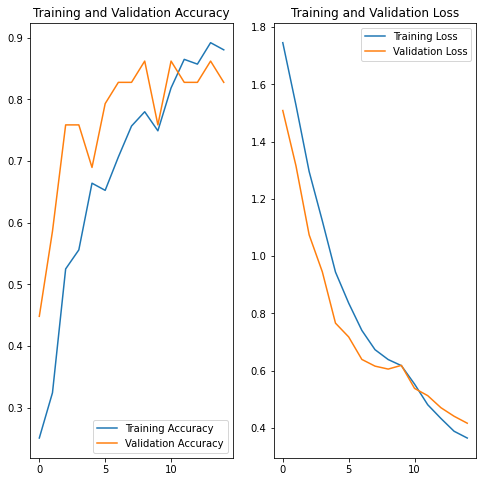

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [68]:
model.save('kumori.h5')

## Test ##

In [69]:
model.evaluate(test_dataset,batch_size = BATCH_SIZE)

3/3 [==============================] - 0s 8ms/step - loss: 0.5040 - accuracy: 0.8056


[0.5040113925933838, 0.8055555820465088]